In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jax_np
from jax import vmap as jax_vmap
from jax import grad as jax_grad
from jax import jit as jax_jit
from jax import random as jax_ran
from jax.experimental import stax,optimizers
from jax.experimental.stax import Dense, Relu

In [2]:
dataset=np.load('data_ML_Nfreq100_Nbeta20_Nlambda20.npz',allow_pickle=True)
print(dataset.files)

['data', 'freq', 'params']


In [3]:
S= dataset['data']
Fr= dataset['freq']
parametre= dataset['params']

In [4]:
S_cnn=np.copy(S)
parametre_cnn=np.copy(parametre)

In [5]:
S_cnn=S_cnn[0:400,:,:]

In [6]:
parameter_cnn=parametre_cnn[0:400,:]

In [7]:
# cette fonction normalise seulement une forme d'onde pour un canal "X","Y","Z"
def normalize_cnn(S,n,e):
# n nombre de FO, e nombre de canal
    
    return np.asarray([S[n,i,e]/np.linalg.norm(S[n,:,e]) for i in range(S.shape[1])])

# return un tableau contenant chaque forme d'onde normalisée

In [8]:
S1_cnn=normalize_cnn(S,10,0)
S1_cnn[0:2]

array([-0.0044968 -0.00040616j, -0.00448933-0.00046114j])

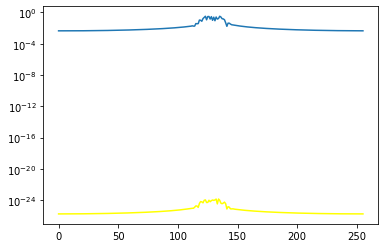

In [9]:
#plt.figure(figsize=(20,12))
plt.semilogy(np.abs(S1_cnn))
plt.semilogy(np.abs(S_cnn[0,:,0]),color='yellow')
#plt.semilogy(np.abs(S_canalXYZ[0,:,0]),color='red')

In [10]:
nb_fo=400 # nombre de FO utilisable pour l'apprentissage du réseau de neurones (400)

In [11]:
# cette fonction rassemble toutes les formes d'onde normalisée dans un seul tableau 
# n nombre de forme d'onde , e numéro du  canal ("X","Y","Z")
def norm_cnn(S):
    
    return (np.asarray([[normalize_cnn(S,n,e) for e in range (S.shape[-1])] for n in range(nb_fo)]))
# pour les n=400 premières formes d'ondes

In [12]:
S_bar_cnn=norm_cnn(S)
S_bar_cnn[0,0]

array([ 4.08759846e-03+1.80176148e-03j,  4.06607859e-03+1.85225583e-03j,
        4.04454545e-03+1.90277852e-03j,  4.02299257e-03+1.95334482e-03j,
        4.00141347e-03+2.00397006e-03j,  3.97980161e-03+2.05466965e-03j,
        3.95815042e-03+2.10545908e-03j,  3.93645331e-03+2.15635395e-03j,
        3.91470360e-03+2.20736999e-03j,  3.89289457e-03+2.25852307e-03j,
        3.87101941e-03+2.30982923e-03j,  3.84907124e-03+2.36130471e-03j,
        3.82704311e-03+2.41296595e-03j,  3.80492794e-03+2.46482960e-03j,
        3.78271855e-03+2.51691260e-03j,  3.76040767e-03+2.56923214e-03j,
        3.73798786e-03+2.62180572e-03j,  3.71545160e-03+2.67465115e-03j,
        3.69279116e-03+2.72778661e-03j,  3.66999870e-03+2.78123063e-03j,
        3.64706618e-03+2.83500217e-03j,  3.62398541e-03+2.88912059e-03j,
        3.60074798e-03+2.94360575e-03j,  3.57734528e-03+2.99847796e-03j,
        3.55376848e-03+3.05375808e-03j,  3.53000853e-03+3.10946753e-03j,
        3.50605610e-03+3.16562831e-03j,  3.48190164

In [13]:
S_bar_cnn.shape

(400, 3, 256)

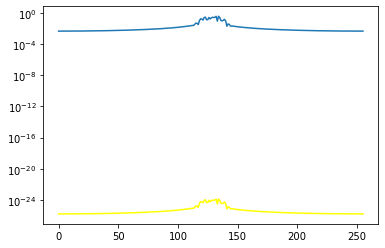

In [14]:
#plt.figure(figsize=(20,12))
plt.semilogy(np.abs(S_bar_cnn[0,0,:]))
plt.semilogy(np.abs(S_cnn[0,:,0]),color='yellow')
#plt.sem

In [15]:
Nb_ampli_diff=10 # réprésente le nombre d'amplitude différente
X_cnn=np.array([np.random.uniform(1,20,Nb_ampli_diff) for _ in range(nb_fo)])
X_cnn[10]

array([18.98231576, 13.16269825, 17.89077576,  6.46874752,  5.79479911,
        4.8340465 , 13.77022427,  9.09020154, 18.5079907 ,  6.02019938])

In [16]:
alpha=np.sqrt(256*X_cnn/2)
alpha

array([[32.66584952, 49.34013096, 27.97133575, ..., 38.23146793,
        45.8932337 , 29.08463293],
       [13.73030494, 44.7867506 , 25.83627349, ..., 49.58838025,
        43.07749389, 29.18666957],
       [25.64889315, 32.51516023, 47.82700098, ..., 35.84679765,
        49.16345963, 37.86254642],
       ...,
       [44.98579732, 39.10479376, 43.67991737, ..., 43.90161209,
        38.55556758, 17.54911124],
       [36.65291262, 41.34231802, 42.70649679, ..., 50.14071706,
        39.09791668, 49.51042975],
       [32.16963895, 26.00730006, 42.27599875, ..., 49.44734865,
        31.72789569, 33.22642201]])

In [17]:
def amplitude_cnn(S,n):
    
    return np.asarray([S[n,:,:]*i for i in alpha[n]])

In [18]:
# cette fonction retourne les 5 amplitudes différentes de chaque FO
def amp_cnn(S):
     
    return (np.asarray([amplitude_cnn(S,n) for n in range(nb_fo)])).reshape((-1,3,256))
# chaque FO retourne 5 sous formes d'onde d'amplitude différentes chacune ayant 2827 fréquences 





In [19]:
S_tilde_cnn=amp_cnn(S_bar_cnn)

In [20]:
S_tilde_cnn.shape

(4000, 3, 256)

###  2. Using $parametre $ for pre_processing

In [21]:
amplitude=parametre_cnn[:,0] # amplitude
beta=parametre_cnn[:,6] # bêta
lamb=parametre_cnn[:,7] # lambda
#parameters=[]
#zz=np.concatenate((amplitude[0:2],beta[0:2]))
parameters_cnn=np.asarray([(i,j,k)for i,j,k in zip(amplitude,beta,lamb)] )

parameters_cnn.shape



(40000, 3)

In [22]:
def ParametersAmpli_cnn(data): # c canal utilisé
    h_bar=[parameters_cnn[i,0]/np.linalg.norm(data[i,:,:]) for i in range(nb_fo)]
    h_tilde_cnn=np.asarray([[h_bar[j]*i for i in alpha[j]]for j in range(nb_fo)])
    lam_cnn=np.array([[u]*Nb_ampli_diff for u in lamb ])
    bet_cnn=np.array([[v]*Nb_ampli_diff for v in beta])
    return h_tilde_cnn,bet_cnn,lam_cnn



In [23]:
h_tilde_cnn,bet_cnn,lam_cnn=ParametersAmpli_cnn(S_cnn)

In [24]:
final_params_cnn=np.asarray([[(i,j,k)for i,j,k in zip(h_tilde_cnn[n,:],bet_cnn[n,:],lam_cnn[n,:])] for n in range(nb_fo)])

In [25]:
final_params_cnn=np.reshape(final_params_cnn,(-1,3))

In [26]:
final_params_cnn.shape

(4000, 3)

In [27]:
h_mean=np.mean(final_params_cnn[:,0])
h_max_mean=np.max(np.abs(final_params_cnn[:,0]-h_mean))

beta_mean=np.mean(final_params_cnn[:,1])
beta_max_mean=np.max(np.abs(final_params_cnn[:,1]-beta_mean))

lam_mean=np.mean(final_params_cnn[:,2])
lam_max_mean=np.max(np.abs(final_params_cnn[:,2]-lam_mean))



In [28]:
def maximum_absolute_scaling_cnn(param):
    n=3
    h,beta,lambd =[],[],[]
    for i in range(n):
        for j in range(len(param)):
            if i==0:
                H=(param[j,i]-h_mean)/h_max_mean
                h.append(H)
            elif i==1:
                Beta=(param[j,i]-beta_mean)/beta_max_mean
                beta.append(Beta)
            
            else:
                
                Lambd=(param[j,i]-lam_mean)/lam_max_mean
                lambd.append(Lambd)
                                                              
                                                              
    return h,beta,lambd

In [29]:
h,b,l=maximum_absolute_scaling_cnn(final_params_cnn)

In [30]:
par=np.asarray([(i,j,k)for i,j,k in zip(h,b,l)])

In [31]:
par

array([[-1.68492643e-01, -5.92913888e-01, -1.00000000e+00],
       [ 4.84364782e-01, -5.92913888e-01, -1.00000000e+00],
       [-3.52299555e-01, -5.92913888e-01, -1.00000000e+00],
       ...,
       [ 8.09247528e-01,  1.00000000e+00,  1.00000000e+00],
       [ 5.50553263e-04,  1.00000000e+00,  1.00000000e+00],
       [ 6.89417000e-02,  1.00000000e+00,  1.00000000e+00]])

#  II. Learning

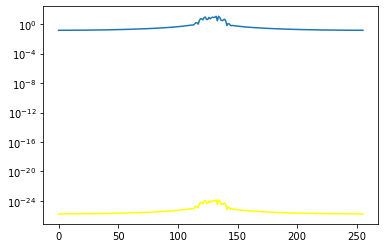

In [32]:
plt.semilogy(np.abs(S_tilde_cnn[0,0,:]))
plt.semilogy(np.abs(S_cnn[0,:,0]),color='yellow')

In [33]:
# we can use par or final_data to do the splitting
from sklearn.model_selection import train_test_split
X_train_cnn,X_test_cnn,Y_train_cnn,Y_test_cnn=train_test_split(S_tilde_cnn,par,test_size=0.20,random_state=42)

In [34]:
X_trainR_cnn=np.real(X_train_cnn[:,:,:]) # 1600 échantillons 
X_trainI_cnn=np.imag(X_train_cnn[:,:,:])# 1600 échantillons 
X_Tr_cnn=np.concatenate((X_trainR_cnn,X_trainI_cnn),axis=1)

In [35]:
X_testR_cnn=np.real(X_test_cnn[:,:,:]) # 400 échantillons 
X_testI_cnn=np.imag(X_test_cnn[:,:,:])# 400 échantillons 
X_Te_cnn=np.concatenate((X_testR_cnn,X_testI_cnn),axis=1)

X_Te_cnn.shape

(800, 6, 256)

In [36]:
from jax.experimental import stax
from jax.experimental.stax import (GeneralConv,Conv, Dense, Flatten,     
                                   Relu,MaxPool)    # neural network layers

In [37]:
num_classes=3
num_epochs =1000
batch_size=200
num_batches=8

In [38]:
key=jax_ran.PRNGKey(0)

In [96]:
### Convolutional Neural network

# conv net convention
dim_nums=('NCHW', 'OIHW', 'NCHW') # default for (input, filters, output)

# define functions which initialize the parameters and evaluate the model
initialize_params, predict = stax.serial(    
                                            ### convolutional NN (CNN)
                                            GeneralConv(dim_nums,32, (4,4), padding="SAME" ), # 36 output channels, (4,4) filter
                                            Relu,
                                            #MaxPool((2, 1),padding="SAME"),
                                            GeneralConv(dim_nums,16, (3,3), padding="SAME" ), # 16 output channels, (3,3) filter
                                            Relu,
                                           # MaxPool((2, 1),padding="SAME"),
                                            Flatten, # flatten output
                                            #Dense(256), # 256 hidden neurons
                                            #Relu,
                                            Dense(num_classes), # 3 output neurons
                                        )

# initialize the model parameters
output_shape, params = initialize_params(key, (batch_size,6, 256,1)) # conv layer, 6 input channel

print('\noutput shape of the model is {}.\n'.format(output_shape))



output shape of the model is (200, 3).



In [97]:
np.asarray(params).shape

/Users/ky266509/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(6,)

In [98]:
W,B = params[2]
print(W.shape,B.shape)

(16, 32, 3, 3) (1, 16, 1, 1)


In [99]:
X_Tr_cnn.shape

(3200, 6, 256)

In [100]:
X=np.reshape(X_Tr_cnn,(-1,6,256,1))
X.ndim    # 6 input_channel, 256*1(Height*width), N: batch_size

4

In [101]:
pr = predict(params, X)

In [102]:
pr.shape

(3200, 3)

In [103]:
def mse_loss(params, in_array, targets):
    preds = predict(params, in_array)
    diff_Ampli = [(preds[i,0]-targets[i,0])**2/preds.shape[0] for i in range(preds.shape[0])]
    diff_Beta = [(preds[j,1]-targets[j,1])**2/preds.shape[0] for j in range(preds.shape[0])]
    diff_lambda = [(preds[k,2]-targets[k,2])**2/preds.shape[0] for k in range(preds.shape[0])]
    error=sum(diff_Ampli) + sum(diff_Beta) + sum(diff_lambda)
    return error

In [104]:
mse_loss(params,X,Y_train_cnn)

DeviceArray(0.8003017, dtype=float32)

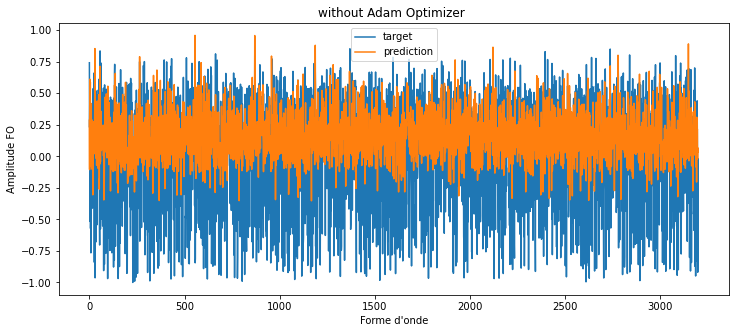

In [105]:
plt.figure(figsize=(12,5))
plt.plot(Y_train_cnn[:,0],label='target')
plt.plot(pr[:,0],label='prediction')
plt.ylabel('Amplitude FO')
plt.xlabel("Forme d'onde")
plt.title('without Adam Optimizer ')
plt.legend()

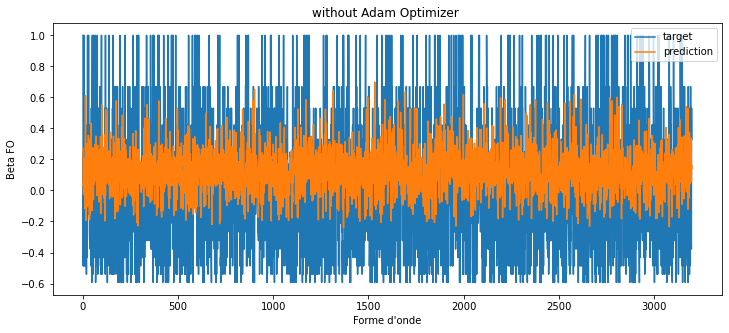

In [106]:
plt.figure(figsize=(12,5))
plt.plot(Y_train_cnn[:,1],label='target')
plt.plot(pr[:,1],label='prediction')
plt.ylabel('Beta FO')
plt.xlabel("Forme d'onde")
plt.title('without Adam Optimizer ')
plt.legend()

In [107]:
# Defining an optimizer in Jax
learning_rate= 1e-3
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params) # init avce les paramètre du réseau

# Define a compiled update step
@jax_jit
def update(i, opt_state, x, y):
    p = get_params(opt_state)
    g = jax_grad(mse_loss)(p, x, y)
    loss=mse_loss(p,x,y)
    return opt_update(i, g, opt_state),loss



In [108]:
from jax import lax
import time
def run_func_cnn(opt_state,X,Y):
    Los=[]
# Adam optimisation
    start_time = time.time()
    for epoch in range(num_epochs):
        for batch_idx in range(num_batches):
            j = epoch // num_batches
            batch_X = lax.dynamic_slice_in_dim(X, j * batch_size, batch_size)
            batch_Y = lax.dynamic_slice_in_dim(Y, j * batch_size, batch_size)
            opt_state ,loss = update(epoch, opt_state,batch_X,batch_Y)
            batch_time = time.time() - start_time
            Los.append(loss)
            print("Batch {} | T: {:0.2f} | MSE: {:0.2f} |".format(batch_idx, batch_time, loss))
    return get_params(opt_state),Los
#net_params = get_params(opt_state)

In [109]:
net_params_cnn,Loss_cnn=run_func_cnn(opt_state,X,Y_train_cnn)

Batch 0 | T: 33.29 | MSE: 0.83 |
Batch 1 | T: 33.39 | MSE: 0.75 |
Batch 2 | T: 33.48 | MSE: 0.68 |
Batch 3 | T: 33.56 | MSE: 0.62 |
Batch 4 | T: 33.67 | MSE: 0.57 |
Batch 5 | T: 33.76 | MSE: 0.51 |
Batch 6 | T: 33.84 | MSE: 0.47 |
Batch 7 | T: 33.96 | MSE: 0.42 |
Batch 0 | T: 34.04 | MSE: 0.39 |
Batch 1 | T: 34.12 | MSE: 0.37 |
Batch 2 | T: 34.23 | MSE: 0.35 |
Batch 3 | T: 34.31 | MSE: 0.33 |
Batch 4 | T: 34.39 | MSE: 0.32 |
Batch 5 | T: 34.49 | MSE: 0.31 |
Batch 6 | T: 34.58 | MSE: 0.29 |
Batch 7 | T: 34.66 | MSE: 0.27 |
Batch 0 | T: 34.76 | MSE: 0.25 |
Batch 1 | T: 34.84 | MSE: 0.24 |
Batch 2 | T: 34.92 | MSE: 0.23 |
Batch 3 | T: 35.03 | MSE: 0.21 |
Batch 4 | T: 35.11 | MSE: 0.20 |
Batch 5 | T: 35.21 | MSE: 0.19 |
Batch 6 | T: 35.31 | MSE: 0.18 |
Batch 7 | T: 35.39 | MSE: 0.17 |
Batch 0 | T: 35.48 | MSE: 0.17 |
Batch 1 | T: 35.58 | MSE: 0.16 |
Batch 2 | T: 35.67 | MSE: 0.16 |
Batch 3 | T: 35.75 | MSE: 0.16 |
Batch 4 | T: 35.85 | MSE: 0.15 |
Batch 5 | T: 35.94 | MSE: 0.15 |
Batch 6 | 

Batch 2 | T: 56.15 | MSE: 0.09 |
Batch 3 | T: 56.33 | MSE: 0.09 |
Batch 4 | T: 56.42 | MSE: 0.09 |
Batch 5 | T: 56.51 | MSE: 0.09 |
Batch 6 | T: 56.61 | MSE: 0.09 |
Batch 7 | T: 56.69 | MSE: 0.09 |
Batch 0 | T: 56.77 | MSE: 0.14 |
Batch 1 | T: 56.87 | MSE: 0.13 |
Batch 2 | T: 56.98 | MSE: 0.13 |
Batch 3 | T: 57.09 | MSE: 0.13 |
Batch 4 | T: 57.20 | MSE: 0.12 |
Batch 5 | T: 57.30 | MSE: 0.12 |
Batch 6 | T: 57.42 | MSE: 0.12 |
Batch 7 | T: 57.54 | MSE: 0.11 |
Batch 0 | T: 57.64 | MSE: 0.11 |
Batch 1 | T: 57.72 | MSE: 0.11 |
Batch 2 | T: 57.82 | MSE: 0.11 |
Batch 3 | T: 57.90 | MSE: 0.11 |
Batch 4 | T: 57.99 | MSE: 0.11 |
Batch 5 | T: 58.09 | MSE: 0.10 |
Batch 6 | T: 58.17 | MSE: 0.10 |
Batch 7 | T: 58.26 | MSE: 0.10 |
Batch 0 | T: 58.36 | MSE: 0.10 |
Batch 1 | T: 58.44 | MSE: 0.10 |
Batch 2 | T: 58.53 | MSE: 0.10 |
Batch 3 | T: 58.63 | MSE: 0.10 |
Batch 4 | T: 58.72 | MSE: 0.10 |
Batch 5 | T: 58.80 | MSE: 0.09 |
Batch 6 | T: 58.90 | MSE: 0.09 |
Batch 7 | T: 58.98 | MSE: 0.09 |
Batch 0 | 

Batch 4 | T: 83.53 | MSE: 0.08 |
Batch 5 | T: 83.65 | MSE: 0.08 |
Batch 6 | T: 83.76 | MSE: 0.08 |
Batch 7 | T: 83.98 | MSE: 0.08 |
Batch 0 | T: 84.08 | MSE: 0.08 |
Batch 1 | T: 84.25 | MSE: 0.08 |
Batch 2 | T: 84.41 | MSE: 0.08 |
Batch 3 | T: 84.54 | MSE: 0.08 |
Batch 4 | T: 84.66 | MSE: 0.08 |
Batch 5 | T: 84.77 | MSE: 0.08 |
Batch 6 | T: 84.88 | MSE: 0.08 |
Batch 7 | T: 85.01 | MSE: 0.08 |
Batch 0 | T: 85.16 | MSE: 0.21 |
Batch 1 | T: 85.28 | MSE: 0.20 |
Batch 2 | T: 85.54 | MSE: 0.20 |
Batch 3 | T: 85.66 | MSE: 0.19 |
Batch 4 | T: 85.75 | MSE: 0.18 |
Batch 5 | T: 85.84 | MSE: 0.17 |
Batch 6 | T: 85.94 | MSE: 0.16 |
Batch 7 | T: 86.05 | MSE: 0.15 |
Batch 0 | T: 86.16 | MSE: 0.15 |
Batch 1 | T: 86.25 | MSE: 0.15 |
Batch 2 | T: 86.34 | MSE: 0.14 |
Batch 3 | T: 86.43 | MSE: 0.14 |
Batch 4 | T: 86.51 | MSE: 0.14 |
Batch 5 | T: 86.60 | MSE: 0.13 |
Batch 6 | T: 86.69 | MSE: 0.13 |
Batch 7 | T: 86.78 | MSE: 0.13 |
Batch 0 | T: 86.87 | MSE: 0.13 |
Batch 1 | T: 86.95 | MSE: 0.12 |
Batch 2 | 

Batch 5 | T: 106.55 | MSE: 0.06 |
Batch 6 | T: 106.64 | MSE: 0.06 |
Batch 7 | T: 106.72 | MSE: 0.05 |
Batch 0 | T: 106.80 | MSE: 0.05 |
Batch 1 | T: 106.89 | MSE: 0.05 |
Batch 2 | T: 106.97 | MSE: 0.05 |
Batch 3 | T: 107.05 | MSE: 0.05 |
Batch 4 | T: 107.14 | MSE: 0.05 |
Batch 5 | T: 107.22 | MSE: 0.05 |
Batch 6 | T: 107.30 | MSE: 0.05 |
Batch 7 | T: 107.39 | MSE: 0.05 |
Batch 0 | T: 107.47 | MSE: 0.05 |
Batch 1 | T: 107.55 | MSE: 0.05 |
Batch 2 | T: 107.64 | MSE: 0.05 |
Batch 3 | T: 107.72 | MSE: 0.05 |
Batch 4 | T: 107.80 | MSE: 0.05 |
Batch 5 | T: 107.88 | MSE: 0.05 |
Batch 6 | T: 107.96 | MSE: 0.04 |
Batch 7 | T: 108.04 | MSE: 0.04 |
Batch 0 | T: 108.13 | MSE: 0.16 |
Batch 1 | T: 108.21 | MSE: 0.15 |
Batch 2 | T: 108.29 | MSE: 0.15 |
Batch 3 | T: 108.46 | MSE: 0.14 |
Batch 4 | T: 108.56 | MSE: 0.14 |
Batch 5 | T: 108.65 | MSE: 0.13 |
Batch 6 | T: 108.73 | MSE: 0.13 |
Batch 7 | T: 108.82 | MSE: 0.12 |
Batch 0 | T: 108.90 | MSE: 0.12 |
Batch 1 | T: 108.99 | MSE: 0.12 |
Batch 2 | T: 1

Batch 0 | T: 128.73 | MSE: 0.07 |
Batch 1 | T: 128.81 | MSE: 0.07 |
Batch 2 | T: 128.90 | MSE: 0.07 |
Batch 3 | T: 128.98 | MSE: 0.07 |
Batch 4 | T: 129.06 | MSE: 0.07 |
Batch 5 | T: 129.14 | MSE: 0.07 |
Batch 6 | T: 129.22 | MSE: 0.07 |
Batch 7 | T: 129.31 | MSE: 0.07 |
Batch 0 | T: 129.39 | MSE: 0.07 |
Batch 1 | T: 129.47 | MSE: 0.07 |
Batch 2 | T: 129.55 | MSE: 0.07 |
Batch 3 | T: 129.64 | MSE: 0.07 |
Batch 4 | T: 129.72 | MSE: 0.07 |
Batch 5 | T: 129.80 | MSE: 0.07 |
Batch 6 | T: 129.88 | MSE: 0.07 |
Batch 7 | T: 129.96 | MSE: 0.07 |
Batch 0 | T: 130.05 | MSE: 0.06 |
Batch 1 | T: 130.13 | MSE: 0.06 |
Batch 2 | T: 130.22 | MSE: 0.06 |
Batch 3 | T: 130.30 | MSE: 0.06 |
Batch 4 | T: 130.38 | MSE: 0.06 |
Batch 5 | T: 130.47 | MSE: 0.06 |
Batch 6 | T: 130.55 | MSE: 0.06 |
Batch 7 | T: 130.63 | MSE: 0.06 |
Batch 0 | T: 130.71 | MSE: 0.06 |
Batch 1 | T: 130.80 | MSE: 0.06 |
Batch 2 | T: 130.88 | MSE: 0.06 |
Batch 3 | T: 130.96 | MSE: 0.06 |
Batch 4 | T: 131.04 | MSE: 0.06 |
Batch 5 | T: 1

Batch 1 | T: 151.64 | MSE: 0.04 |
Batch 2 | T: 151.78 | MSE: 0.04 |
Batch 3 | T: 151.88 | MSE: 0.04 |
Batch 4 | T: 151.97 | MSE: 0.04 |
Batch 5 | T: 152.17 | MSE: 0.04 |
Batch 6 | T: 152.31 | MSE: 0.04 |
Batch 7 | T: 152.40 | MSE: 0.04 |
Batch 0 | T: 152.48 | MSE: 0.04 |
Batch 1 | T: 152.57 | MSE: 0.04 |
Batch 2 | T: 152.65 | MSE: 0.04 |
Batch 3 | T: 152.73 | MSE: 0.04 |
Batch 4 | T: 152.81 | MSE: 0.04 |
Batch 5 | T: 152.91 | MSE: 0.04 |
Batch 6 | T: 153.00 | MSE: 0.04 |
Batch 7 | T: 153.12 | MSE: 0.04 |
Batch 0 | T: 153.26 | MSE: 0.04 |
Batch 1 | T: 153.38 | MSE: 0.04 |
Batch 2 | T: 153.48 | MSE: 0.04 |
Batch 3 | T: 153.58 | MSE: 0.04 |
Batch 4 | T: 153.71 | MSE: 0.04 |
Batch 5 | T: 153.80 | MSE: 0.04 |
Batch 6 | T: 153.88 | MSE: 0.04 |
Batch 7 | T: 153.96 | MSE: 0.04 |
Batch 0 | T: 154.04 | MSE: 0.04 |
Batch 1 | T: 154.13 | MSE: 0.04 |
Batch 2 | T: 154.22 | MSE: 0.04 |
Batch 3 | T: 154.30 | MSE: 0.04 |
Batch 4 | T: 154.39 | MSE: 0.04 |
Batch 5 | T: 154.48 | MSE: 0.04 |
Batch 6 | T: 1

Batch 2 | T: 173.26 | MSE: 0.03 |
Batch 3 | T: 173.35 | MSE: 0.03 |
Batch 4 | T: 173.43 | MSE: 0.03 |
Batch 5 | T: 173.51 | MSE: 0.03 |
Batch 6 | T: 173.59 | MSE: 0.03 |
Batch 7 | T: 173.67 | MSE: 0.03 |
Batch 0 | T: 173.76 | MSE: 0.03 |
Batch 1 | T: 173.84 | MSE: 0.03 |
Batch 2 | T: 173.92 | MSE: 0.03 |
Batch 3 | T: 174.00 | MSE: 0.03 |
Batch 4 | T: 174.09 | MSE: 0.03 |
Batch 5 | T: 174.17 | MSE: 0.03 |
Batch 6 | T: 174.25 | MSE: 0.03 |
Batch 7 | T: 174.34 | MSE: 0.03 |
Batch 0 | T: 174.42 | MSE: 0.03 |
Batch 1 | T: 174.50 | MSE: 0.03 |
Batch 2 | T: 174.58 | MSE: 0.03 |
Batch 3 | T: 174.66 | MSE: 0.03 |
Batch 4 | T: 174.75 | MSE: 0.03 |
Batch 5 | T: 174.83 | MSE: 0.03 |
Batch 6 | T: 174.91 | MSE: 0.03 |
Batch 7 | T: 174.99 | MSE: 0.03 |
Batch 0 | T: 175.08 | MSE: 0.03 |
Batch 1 | T: 175.16 | MSE: 0.03 |
Batch 2 | T: 175.24 | MSE: 0.03 |
Batch 3 | T: 175.32 | MSE: 0.03 |
Batch 4 | T: 175.40 | MSE: 0.03 |
Batch 5 | T: 175.48 | MSE: 0.03 |
Batch 6 | T: 175.57 | MSE: 0.03 |
Batch 7 | T: 1

Batch 3 | T: 196.56 | MSE: 0.02 |
Batch 4 | T: 196.65 | MSE: 0.02 |
Batch 5 | T: 196.74 | MSE: 0.02 |
Batch 6 | T: 196.82 | MSE: 0.02 |
Batch 7 | T: 196.92 | MSE: 0.02 |
Batch 0 | T: 197.00 | MSE: 0.02 |
Batch 1 | T: 197.08 | MSE: 0.02 |
Batch 2 | T: 197.18 | MSE: 0.02 |
Batch 3 | T: 197.26 | MSE: 0.02 |
Batch 4 | T: 197.34 | MSE: 0.02 |
Batch 5 | T: 197.44 | MSE: 0.02 |
Batch 6 | T: 197.52 | MSE: 0.02 |
Batch 7 | T: 197.61 | MSE: 0.02 |
Batch 0 | T: 197.70 | MSE: 0.02 |
Batch 1 | T: 197.78 | MSE: 0.02 |
Batch 2 | T: 197.86 | MSE: 0.02 |
Batch 3 | T: 197.96 | MSE: 0.02 |
Batch 4 | T: 198.04 | MSE: 0.02 |
Batch 5 | T: 198.12 | MSE: 0.02 |
Batch 6 | T: 198.22 | MSE: 0.02 |
Batch 7 | T: 198.31 | MSE: 0.02 |
Batch 0 | T: 198.39 | MSE: 0.02 |
Batch 1 | T: 198.48 | MSE: 0.02 |
Batch 2 | T: 198.57 | MSE: 0.02 |
Batch 3 | T: 198.65 | MSE: 0.02 |
Batch 4 | T: 198.75 | MSE: 0.02 |
Batch 5 | T: 198.85 | MSE: 0.02 |
Batch 6 | T: 198.93 | MSE: 0.02 |
Batch 7 | T: 199.03 | MSE: 0.02 |
Batch 0 | T: 1

Batch 5 | T: 218.23 | MSE: 0.02 |
Batch 6 | T: 218.33 | MSE: 0.02 |
Batch 7 | T: 218.43 | MSE: 0.02 |
Batch 0 | T: 218.53 | MSE: 0.02 |
Batch 1 | T: 218.65 | MSE: 0.02 |
Batch 2 | T: 218.75 | MSE: 0.02 |
Batch 3 | T: 218.86 | MSE: 0.02 |
Batch 4 | T: 218.97 | MSE: 0.02 |
Batch 5 | T: 219.08 | MSE: 0.02 |
Batch 6 | T: 219.19 | MSE: 0.02 |
Batch 7 | T: 219.28 | MSE: 0.02 |
Batch 0 | T: 219.36 | MSE: 0.02 |
Batch 1 | T: 219.46 | MSE: 0.02 |
Batch 2 | T: 219.54 | MSE: 0.02 |
Batch 3 | T: 219.62 | MSE: 0.02 |
Batch 4 | T: 219.72 | MSE: 0.02 |
Batch 5 | T: 219.80 | MSE: 0.02 |
Batch 6 | T: 219.88 | MSE: 0.02 |
Batch 7 | T: 219.98 | MSE: 0.02 |
Batch 0 | T: 220.07 | MSE: 0.02 |
Batch 1 | T: 220.15 | MSE: 0.02 |
Batch 2 | T: 220.24 | MSE: 0.02 |
Batch 3 | T: 220.33 | MSE: 0.02 |
Batch 4 | T: 220.41 | MSE: 0.02 |
Batch 5 | T: 220.51 | MSE: 0.02 |
Batch 6 | T: 220.59 | MSE: 0.02 |
Batch 7 | T: 220.67 | MSE: 0.02 |
Batch 0 | T: 220.77 | MSE: 0.02 |
Batch 1 | T: 220.85 | MSE: 0.02 |
Batch 2 | T: 2

Batch 0 | T: 240.02 | MSE: 0.01 |
Batch 1 | T: 240.12 | MSE: 0.01 |
Batch 2 | T: 240.21 | MSE: 0.01 |
Batch 3 | T: 240.29 | MSE: 0.01 |
Batch 4 | T: 240.38 | MSE: 0.01 |
Batch 5 | T: 240.47 | MSE: 0.01 |
Batch 6 | T: 240.55 | MSE: 0.01 |
Batch 7 | T: 240.66 | MSE: 0.01 |
Batch 0 | T: 240.75 | MSE: 0.01 |
Batch 1 | T: 240.83 | MSE: 0.01 |
Batch 2 | T: 240.92 | MSE: 0.01 |
Batch 3 | T: 241.01 | MSE: 0.01 |
Batch 4 | T: 241.09 | MSE: 0.01 |
Batch 5 | T: 241.19 | MSE: 0.01 |
Batch 6 | T: 241.27 | MSE: 0.01 |
Batch 7 | T: 241.36 | MSE: 0.01 |
Batch 0 | T: 241.45 | MSE: 0.01 |
Batch 1 | T: 241.54 | MSE: 0.01 |
Batch 2 | T: 241.62 | MSE: 0.01 |
Batch 3 | T: 241.71 | MSE: 0.01 |
Batch 4 | T: 241.80 | MSE: 0.01 |
Batch 5 | T: 241.87 | MSE: 0.01 |
Batch 6 | T: 241.97 | MSE: 0.01 |
Batch 7 | T: 242.06 | MSE: 0.01 |
Batch 0 | T: 242.14 | MSE: 0.01 |
Batch 1 | T: 242.24 | MSE: 0.01 |
Batch 2 | T: 242.33 | MSE: 0.01 |
Batch 3 | T: 242.41 | MSE: 0.01 |
Batch 4 | T: 242.50 | MSE: 0.01 |
Batch 5 | T: 2

Batch 3 | T: 261.80 | MSE: 0.01 |
Batch 4 | T: 261.90 | MSE: 0.01 |
Batch 5 | T: 261.98 | MSE: 0.01 |
Batch 6 | T: 262.06 | MSE: 0.01 |
Batch 7 | T: 262.16 | MSE: 0.01 |
Batch 0 | T: 262.24 | MSE: 0.01 |
Batch 1 | T: 262.32 | MSE: 0.01 |
Batch 2 | T: 262.42 | MSE: 0.01 |
Batch 3 | T: 262.50 | MSE: 0.01 |
Batch 4 | T: 262.58 | MSE: 0.01 |
Batch 5 | T: 262.68 | MSE: 0.01 |
Batch 6 | T: 262.76 | MSE: 0.01 |
Batch 7 | T: 262.84 | MSE: 0.01 |
Batch 0 | T: 262.94 | MSE: 0.01 |
Batch 1 | T: 263.02 | MSE: 0.01 |
Batch 2 | T: 263.10 | MSE: 0.01 |
Batch 3 | T: 263.20 | MSE: 0.01 |
Batch 4 | T: 263.28 | MSE: 0.01 |
Batch 5 | T: 263.37 | MSE: 0.01 |
Batch 6 | T: 263.47 | MSE: 0.01 |
Batch 7 | T: 263.57 | MSE: 0.01 |
Batch 0 | T: 263.68 | MSE: 0.01 |
Batch 1 | T: 263.80 | MSE: 0.01 |
Batch 2 | T: 263.91 | MSE: 0.01 |
Batch 3 | T: 264.02 | MSE: 0.01 |
Batch 4 | T: 264.12 | MSE: 0.01 |
Batch 5 | T: 264.24 | MSE: 0.01 |
Batch 6 | T: 264.35 | MSE: 0.01 |
Batch 7 | T: 264.46 | MSE: 0.01 |
Batch 0 | T: 2

Batch 4 | T: 283.18 | MSE: 0.01 |
Batch 5 | T: 283.28 | MSE: 0.01 |
Batch 6 | T: 283.36 | MSE: 0.01 |
Batch 7 | T: 283.44 | MSE: 0.01 |
Batch 0 | T: 283.53 | MSE: 0.01 |
Batch 1 | T: 283.62 | MSE: 0.01 |
Batch 2 | T: 283.70 | MSE: 0.01 |
Batch 3 | T: 283.79 | MSE: 0.01 |
Batch 4 | T: 283.88 | MSE: 0.01 |
Batch 5 | T: 283.96 | MSE: 0.01 |
Batch 6 | T: 284.05 | MSE: 0.01 |
Batch 7 | T: 284.13 | MSE: 0.01 |
Batch 0 | T: 284.23 | MSE: 0.01 |
Batch 1 | T: 284.35 | MSE: 0.01 |
Batch 2 | T: 284.44 | MSE: 0.01 |
Batch 3 | T: 284.54 | MSE: 0.01 |
Batch 4 | T: 284.65 | MSE: 0.01 |
Batch 5 | T: 284.75 | MSE: 0.01 |
Batch 6 | T: 284.86 | MSE: 0.01 |
Batch 7 | T: 284.97 | MSE: 0.01 |
Batch 0 | T: 285.06 | MSE: 0.01 |
Batch 1 | T: 285.15 | MSE: 0.01 |
Batch 2 | T: 285.24 | MSE: 0.01 |
Batch 3 | T: 285.32 | MSE: 0.01 |
Batch 4 | T: 285.42 | MSE: 0.01 |
Batch 5 | T: 285.50 | MSE: 0.01 |
Batch 6 | T: 285.58 | MSE: 0.01 |
Batch 7 | T: 285.68 | MSE: 0.01 |
Batch 0 | T: 285.76 | MSE: 0.01 |
Batch 1 | T: 2

Batch 6 | T: 304.65 | MSE: 0.00 |
Batch 7 | T: 304.75 | MSE: 0.00 |
Batch 0 | T: 304.83 | MSE: 0.00 |
Batch 1 | T: 304.91 | MSE: 0.00 |
Batch 2 | T: 305.01 | MSE: 0.00 |
Batch 3 | T: 305.09 | MSE: 0.00 |
Batch 4 | T: 305.18 | MSE: 0.00 |
Batch 5 | T: 305.27 | MSE: 0.00 |
Batch 6 | T: 305.36 | MSE: 0.00 |
Batch 7 | T: 305.44 | MSE: 0.00 |
Batch 0 | T: 305.53 | MSE: 0.00 |
Batch 1 | T: 305.62 | MSE: 0.00 |
Batch 2 | T: 305.70 | MSE: 0.00 |
Batch 3 | T: 305.80 | MSE: 0.00 |
Batch 4 | T: 305.88 | MSE: 0.00 |
Batch 5 | T: 305.96 | MSE: 0.00 |
Batch 6 | T: 306.05 | MSE: 0.00 |
Batch 7 | T: 306.14 | MSE: 0.00 |
Batch 0 | T: 306.22 | MSE: 0.00 |
Batch 1 | T: 306.32 | MSE: 0.00 |
Batch 2 | T: 306.40 | MSE: 0.00 |
Batch 3 | T: 306.48 | MSE: 0.00 |
Batch 4 | T: 306.58 | MSE: 0.00 |
Batch 5 | T: 306.66 | MSE: 0.00 |
Batch 6 | T: 306.74 | MSE: 0.00 |
Batch 7 | T: 306.84 | MSE: 0.00 |
Batch 0 | T: 306.92 | MSE: 0.00 |
Batch 1 | T: 307.00 | MSE: 0.00 |
Batch 2 | T: 307.09 | MSE: 0.00 |
Batch 3 | T: 3

Batch 7 | T: 326.01 | MSE: 0.00 |
Batch 0 | T: 326.12 | MSE: 0.00 |
Batch 1 | T: 326.21 | MSE: 0.00 |
Batch 2 | T: 326.29 | MSE: 0.00 |
Batch 3 | T: 326.40 | MSE: 0.00 |
Batch 4 | T: 326.50 | MSE: 0.00 |
Batch 5 | T: 326.58 | MSE: 0.00 |
Batch 6 | T: 326.68 | MSE: 0.00 |
Batch 7 | T: 326.77 | MSE: 0.00 |
Batch 0 | T: 326.85 | MSE: 0.00 |
Batch 1 | T: 326.94 | MSE: 0.00 |
Batch 2 | T: 327.03 | MSE: 0.00 |
Batch 3 | T: 327.11 | MSE: 0.00 |
Batch 4 | T: 327.20 | MSE: 0.00 |
Batch 5 | T: 327.29 | MSE: 0.00 |
Batch 6 | T: 327.37 | MSE: 0.00 |
Batch 7 | T: 327.46 | MSE: 0.00 |
Batch 0 | T: 327.55 | MSE: 0.00 |
Batch 1 | T: 327.63 | MSE: 0.00 |
Batch 2 | T: 327.72 | MSE: 0.00 |
Batch 3 | T: 327.80 | MSE: 0.00 |
Batch 4 | T: 327.88 | MSE: 0.00 |
Batch 5 | T: 327.98 | MSE: 0.00 |
Batch 6 | T: 328.06 | MSE: 0.00 |
Batch 7 | T: 328.14 | MSE: 0.00 |
Batch 0 | T: 328.24 | MSE: 0.00 |
Batch 1 | T: 328.32 | MSE: 0.00 |
Batch 2 | T: 328.40 | MSE: 0.00 |
Batch 3 | T: 328.50 | MSE: 0.00 |
Batch 4 | T: 3

Batch 0 | T: 347.27 | MSE: 0.00 |
Batch 1 | T: 347.37 | MSE: 0.00 |
Batch 2 | T: 347.45 | MSE: 0.00 |
Batch 3 | T: 347.53 | MSE: 0.00 |
Batch 4 | T: 347.63 | MSE: 0.00 |
Batch 5 | T: 347.72 | MSE: 0.00 |
Batch 6 | T: 347.80 | MSE: 0.00 |
Batch 7 | T: 347.89 | MSE: 0.00 |
Batch 0 | T: 347.97 | MSE: 0.00 |
Batch 1 | T: 348.05 | MSE: 0.00 |
Batch 2 | T: 348.15 | MSE: 0.00 |
Batch 3 | T: 348.24 | MSE: 0.00 |
Batch 4 | T: 348.32 | MSE: 0.00 |
Batch 5 | T: 348.42 | MSE: 0.00 |
Batch 6 | T: 348.50 | MSE: 0.00 |
Batch 7 | T: 348.58 | MSE: 0.00 |
Batch 0 | T: 348.68 | MSE: 0.00 |
Batch 1 | T: 348.77 | MSE: 0.00 |
Batch 2 | T: 348.85 | MSE: 0.00 |
Batch 3 | T: 348.95 | MSE: 0.00 |
Batch 4 | T: 349.03 | MSE: 0.00 |
Batch 5 | T: 349.11 | MSE: 0.00 |
Batch 6 | T: 349.21 | MSE: 0.00 |
Batch 7 | T: 349.29 | MSE: 0.00 |
Batch 0 | T: 349.38 | MSE: 0.00 |
Batch 1 | T: 349.47 | MSE: 0.00 |
Batch 2 | T: 349.55 | MSE: 0.00 |
Batch 3 | T: 349.63 | MSE: 0.00 |
Batch 4 | T: 349.74 | MSE: 0.00 |
Batch 5 | T: 3

Batch 3 | T: 369.10 | MSE: 0.00 |
Batch 4 | T: 369.20 | MSE: 0.00 |
Batch 5 | T: 369.28 | MSE: 0.00 |
Batch 6 | T: 369.36 | MSE: 0.00 |
Batch 7 | T: 369.46 | MSE: 0.00 |
Batch 0 | T: 369.54 | MSE: 0.00 |
Batch 1 | T: 369.62 | MSE: 0.00 |
Batch 2 | T: 369.72 | MSE: 0.00 |
Batch 3 | T: 369.80 | MSE: 0.00 |
Batch 4 | T: 369.88 | MSE: 0.00 |
Batch 5 | T: 369.98 | MSE: 0.00 |
Batch 6 | T: 370.06 | MSE: 0.00 |
Batch 7 | T: 370.14 | MSE: 0.00 |
Batch 0 | T: 370.24 | MSE: 0.00 |
Batch 1 | T: 370.32 | MSE: 0.00 |
Batch 2 | T: 370.41 | MSE: 0.00 |
Batch 3 | T: 370.50 | MSE: 0.00 |
Batch 4 | T: 370.58 | MSE: 0.00 |
Batch 5 | T: 370.66 | MSE: 0.00 |
Batch 6 | T: 370.76 | MSE: 0.00 |
Batch 7 | T: 370.84 | MSE: 0.00 |
Batch 0 | T: 370.93 | MSE: 0.00 |
Batch 1 | T: 371.02 | MSE: 0.00 |
Batch 2 | T: 371.10 | MSE: 0.00 |
Batch 3 | T: 371.19 | MSE: 0.00 |
Batch 4 | T: 371.28 | MSE: 0.00 |
Batch 5 | T: 371.37 | MSE: 0.00 |
Batch 6 | T: 371.45 | MSE: 0.00 |
Batch 7 | T: 371.55 | MSE: 0.00 |
Batch 0 | T: 3

Batch 4 | T: 390.36 | MSE: 0.00 |
Batch 5 | T: 390.46 | MSE: 0.00 |
Batch 6 | T: 390.54 | MSE: 0.00 |
Batch 7 | T: 390.62 | MSE: 0.00 |
Batch 0 | T: 390.72 | MSE: 0.00 |
Batch 1 | T: 390.80 | MSE: 0.00 |
Batch 2 | T: 390.88 | MSE: 0.00 |
Batch 3 | T: 390.97 | MSE: 0.00 |
Batch 4 | T: 391.06 | MSE: 0.00 |
Batch 5 | T: 391.14 | MSE: 0.00 |
Batch 6 | T: 391.24 | MSE: 0.00 |
Batch 7 | T: 391.32 | MSE: 0.00 |
Batch 0 | T: 391.42 | MSE: 0.00 |
Batch 1 | T: 391.54 | MSE: 0.00 |
Batch 2 | T: 391.64 | MSE: 0.00 |
Batch 3 | T: 391.75 | MSE: 0.00 |
Batch 4 | T: 391.86 | MSE: 0.00 |
Batch 5 | T: 391.97 | MSE: 0.00 |
Batch 6 | T: 392.07 | MSE: 0.00 |
Batch 7 | T: 392.19 | MSE: 0.00 |
Batch 0 | T: 392.28 | MSE: 0.00 |
Batch 1 | T: 392.36 | MSE: 0.00 |
Batch 2 | T: 392.46 | MSE: 0.00 |
Batch 3 | T: 392.54 | MSE: 0.00 |
Batch 4 | T: 392.62 | MSE: 0.00 |
Batch 5 | T: 392.72 | MSE: 0.00 |
Batch 6 | T: 392.80 | MSE: 0.00 |
Batch 7 | T: 392.88 | MSE: 0.00 |
Batch 0 | T: 392.97 | MSE: 0.00 |
Batch 1 | T: 3

Batch 7 | T: 412.07 | MSE: 0.00 |
Batch 0 | T: 412.18 | MSE: 0.00 |
Batch 1 | T: 412.27 | MSE: 0.00 |
Batch 2 | T: 412.35 | MSE: 0.00 |
Batch 3 | T: 412.45 | MSE: 0.00 |
Batch 4 | T: 412.53 | MSE: 0.00 |
Batch 5 | T: 412.61 | MSE: 0.00 |
Batch 6 | T: 412.71 | MSE: 0.00 |
Batch 7 | T: 412.80 | MSE: 0.00 |
Batch 0 | T: 412.88 | MSE: 0.00 |
Batch 1 | T: 412.98 | MSE: 0.00 |
Batch 2 | T: 413.06 | MSE: 0.00 |
Batch 3 | T: 413.14 | MSE: 0.00 |
Batch 4 | T: 413.24 | MSE: 0.00 |
Batch 5 | T: 413.33 | MSE: 0.00 |
Batch 6 | T: 413.41 | MSE: 0.00 |
Batch 7 | T: 413.51 | MSE: 0.00 |
Batch 0 | T: 413.59 | MSE: 0.00 |
Batch 1 | T: 413.67 | MSE: 0.00 |
Batch 2 | T: 413.77 | MSE: 0.00 |
Batch 3 | T: 413.85 | MSE: 0.00 |
Batch 4 | T: 413.93 | MSE: 0.00 |
Batch 5 | T: 414.03 | MSE: 0.00 |
Batch 6 | T: 414.11 | MSE: 0.00 |
Batch 7 | T: 414.19 | MSE: 0.00 |
Batch 0 | T: 414.29 | MSE: 0.00 |
Batch 1 | T: 414.37 | MSE: 0.00 |
Batch 2 | T: 414.45 | MSE: 0.00 |
Batch 3 | T: 414.55 | MSE: 0.00 |
Batch 4 | T: 4

Batch 2 | T: 433.59 | MSE: 0.00 |
Batch 3 | T: 433.69 | MSE: 0.00 |
Batch 4 | T: 433.77 | MSE: 0.00 |
Batch 5 | T: 433.85 | MSE: 0.00 |
Batch 6 | T: 433.95 | MSE: 0.00 |
Batch 7 | T: 434.03 | MSE: 0.00 |
Batch 0 | T: 434.11 | MSE: 0.00 |
Batch 1 | T: 434.21 | MSE: 0.00 |
Batch 2 | T: 434.29 | MSE: 0.00 |
Batch 3 | T: 434.37 | MSE: 0.00 |
Batch 4 | T: 434.47 | MSE: 0.00 |
Batch 5 | T: 434.55 | MSE: 0.00 |
Batch 6 | T: 434.63 | MSE: 0.00 |
Batch 7 | T: 434.73 | MSE: 0.00 |
Batch 0 | T: 434.81 | MSE: 0.00 |
Batch 1 | T: 434.89 | MSE: 0.00 |
Batch 2 | T: 434.99 | MSE: 0.00 |
Batch 3 | T: 435.07 | MSE: 0.00 |
Batch 4 | T: 435.15 | MSE: 0.00 |
Batch 5 | T: 435.25 | MSE: 0.00 |
Batch 6 | T: 435.33 | MSE: 0.00 |
Batch 7 | T: 435.41 | MSE: 0.00 |
Batch 0 | T: 435.51 | MSE: 0.00 |
Batch 1 | T: 435.59 | MSE: 0.00 |
Batch 2 | T: 435.67 | MSE: 0.00 |
Batch 3 | T: 435.77 | MSE: 0.00 |
Batch 4 | T: 435.85 | MSE: 0.00 |
Batch 5 | T: 435.93 | MSE: 0.00 |
Batch 6 | T: 436.03 | MSE: 0.00 |
Batch 7 | T: 4

Batch 5 | T: 455.34 | MSE: 0.00 |
Batch 6 | T: 455.44 | MSE: 0.00 |
Batch 7 | T: 455.52 | MSE: 0.00 |
Batch 0 | T: 455.60 | MSE: 0.00 |
Batch 1 | T: 455.70 | MSE: 0.00 |
Batch 2 | T: 455.78 | MSE: 0.00 |
Batch 3 | T: 455.86 | MSE: 0.00 |
Batch 4 | T: 455.96 | MSE: 0.00 |
Batch 5 | T: 456.04 | MSE: 0.00 |
Batch 6 | T: 456.12 | MSE: 0.00 |
Batch 7 | T: 456.23 | MSE: 0.00 |
Batch 0 | T: 456.31 | MSE: 0.00 |
Batch 1 | T: 456.39 | MSE: 0.00 |
Batch 2 | T: 456.49 | MSE: 0.00 |
Batch 3 | T: 456.57 | MSE: 0.00 |
Batch 4 | T: 456.65 | MSE: 0.00 |
Batch 5 | T: 456.75 | MSE: 0.00 |
Batch 6 | T: 456.83 | MSE: 0.00 |
Batch 7 | T: 456.91 | MSE: 0.00 |
Batch 0 | T: 457.01 | MSE: 0.00 |
Batch 1 | T: 457.09 | MSE: 0.00 |
Batch 2 | T: 457.17 | MSE: 0.00 |
Batch 3 | T: 457.27 | MSE: 0.00 |
Batch 4 | T: 457.35 | MSE: 0.00 |
Batch 5 | T: 457.44 | MSE: 0.00 |
Batch 6 | T: 457.53 | MSE: 0.00 |
Batch 7 | T: 457.61 | MSE: 0.00 |
Batch 0 | T: 457.69 | MSE: 0.00 |
Batch 1 | T: 457.79 | MSE: 0.00 |
Batch 2 | T: 4

Batch 0 | T: 477.04 | MSE: 0.00 |
Batch 1 | T: 477.14 | MSE: 0.00 |
Batch 2 | T: 477.22 | MSE: 0.00 |
Batch 3 | T: 477.30 | MSE: 0.00 |
Batch 4 | T: 477.40 | MSE: 0.00 |
Batch 5 | T: 477.49 | MSE: 0.00 |
Batch 6 | T: 477.57 | MSE: 0.00 |
Batch 7 | T: 477.66 | MSE: 0.00 |
Batch 0 | T: 477.75 | MSE: 0.00 |
Batch 1 | T: 477.83 | MSE: 0.00 |
Batch 2 | T: 477.93 | MSE: 0.00 |
Batch 3 | T: 478.01 | MSE: 0.00 |
Batch 4 | T: 478.09 | MSE: 0.00 |
Batch 5 | T: 478.19 | MSE: 0.00 |
Batch 6 | T: 478.27 | MSE: 0.00 |
Batch 7 | T: 478.35 | MSE: 0.00 |
Batch 0 | T: 478.45 | MSE: 0.00 |
Batch 1 | T: 478.54 | MSE: 0.00 |
Batch 2 | T: 478.62 | MSE: 0.00 |
Batch 3 | T: 478.72 | MSE: 0.00 |
Batch 4 | T: 478.81 | MSE: 0.00 |
Batch 5 | T: 478.89 | MSE: 0.00 |
Batch 6 | T: 479.00 | MSE: 0.00 |
Batch 7 | T: 479.08 | MSE: 0.00 |
Batch 0 | T: 479.17 | MSE: 0.00 |
Batch 1 | T: 479.27 | MSE: 0.00 |
Batch 2 | T: 479.35 | MSE: 0.00 |
Batch 3 | T: 479.48 | MSE: 0.00 |
Batch 4 | T: 479.63 | MSE: 0.00 |
Batch 5 | T: 4

Batch 2 | T: 504.54 | MSE: 0.00 |
Batch 3 | T: 504.71 | MSE: 0.00 |
Batch 4 | T: 504.82 | MSE: 0.00 |
Batch 5 | T: 504.93 | MSE: 0.00 |
Batch 6 | T: 505.06 | MSE: 0.00 |
Batch 7 | T: 505.17 | MSE: 0.00 |
Batch 0 | T: 505.29 | MSE: 0.00 |
Batch 1 | T: 505.52 | MSE: 0.00 |
Batch 2 | T: 505.62 | MSE: 0.00 |
Batch 3 | T: 505.75 | MSE: 0.00 |
Batch 4 | T: 505.97 | MSE: 0.00 |
Batch 5 | T: 506.07 | MSE: 0.00 |
Batch 6 | T: 506.15 | MSE: 0.00 |
Batch 7 | T: 506.24 | MSE: 0.00 |
Batch 0 | T: 506.34 | MSE: 0.00 |
Batch 1 | T: 506.43 | MSE: 0.00 |
Batch 2 | T: 506.61 | MSE: 0.00 |
Batch 3 | T: 506.74 | MSE: 0.00 |
Batch 4 | T: 506.89 | MSE: 0.00 |
Batch 5 | T: 507.08 | MSE: 0.00 |
Batch 6 | T: 507.17 | MSE: 0.00 |
Batch 7 | T: 507.26 | MSE: 0.00 |
Batch 0 | T: 507.35 | MSE: 0.00 |
Batch 1 | T: 507.45 | MSE: 0.00 |
Batch 2 | T: 507.63 | MSE: 0.00 |
Batch 3 | T: 507.82 | MSE: 0.00 |
Batch 4 | T: 507.92 | MSE: 0.00 |
Batch 5 | T: 508.04 | MSE: 0.00 |
Batch 6 | T: 508.13 | MSE: 0.00 |
Batch 7 | T: 5

Batch 5 | T: 527.93 | MSE: 0.00 |
Batch 6 | T: 528.02 | MSE: 0.00 |
Batch 7 | T: 528.11 | MSE: 0.00 |
Batch 0 | T: 528.19 | MSE: 0.00 |
Batch 1 | T: 528.28 | MSE: 0.00 |
Batch 2 | T: 528.36 | MSE: 0.00 |
Batch 3 | T: 528.45 | MSE: 0.00 |
Batch 4 | T: 528.53 | MSE: 0.00 |
Batch 5 | T: 528.62 | MSE: 0.00 |
Batch 6 | T: 528.70 | MSE: 0.00 |
Batch 7 | T: 528.79 | MSE: 0.00 |
Batch 0 | T: 528.87 | MSE: 0.00 |
Batch 1 | T: 528.95 | MSE: 0.00 |
Batch 2 | T: 529.04 | MSE: 0.00 |
Batch 3 | T: 529.12 | MSE: 0.00 |
Batch 4 | T: 529.21 | MSE: 0.00 |
Batch 5 | T: 529.29 | MSE: 0.00 |
Batch 6 | T: 529.38 | MSE: 0.00 |
Batch 7 | T: 529.46 | MSE: 0.00 |
Batch 0 | T: 529.55 | MSE: 0.00 |
Batch 1 | T: 529.63 | MSE: 0.00 |
Batch 2 | T: 529.71 | MSE: 0.00 |
Batch 3 | T: 529.80 | MSE: 0.00 |
Batch 4 | T: 529.88 | MSE: 0.00 |
Batch 5 | T: 529.97 | MSE: 0.00 |
Batch 6 | T: 530.06 | MSE: 0.00 |
Batch 7 | T: 530.14 | MSE: 0.00 |
Batch 0 | T: 530.23 | MSE: 0.00 |
Batch 1 | T: 530.32 | MSE: 0.00 |
Batch 2 | T: 5

Batch 0 | T: 548.94 | MSE: 0.00 |
Batch 1 | T: 549.02 | MSE: 0.00 |
Batch 2 | T: 549.11 | MSE: 0.00 |
Batch 3 | T: 549.19 | MSE: 0.00 |
Batch 4 | T: 549.28 | MSE: 0.00 |
Batch 5 | T: 549.36 | MSE: 0.00 |
Batch 6 | T: 549.44 | MSE: 0.00 |
Batch 7 | T: 549.53 | MSE: 0.00 |
Batch 0 | T: 549.62 | MSE: 0.00 |
Batch 1 | T: 549.70 | MSE: 0.00 |
Batch 2 | T: 549.79 | MSE: 0.00 |
Batch 3 | T: 549.87 | MSE: 0.00 |
Batch 4 | T: 549.96 | MSE: 0.00 |
Batch 5 | T: 550.05 | MSE: 0.00 |
Batch 6 | T: 550.13 | MSE: 0.00 |
Batch 7 | T: 550.21 | MSE: 0.00 |
Batch 0 | T: 550.30 | MSE: 0.00 |
Batch 1 | T: 550.38 | MSE: 0.00 |
Batch 2 | T: 550.47 | MSE: 0.00 |
Batch 3 | T: 550.60 | MSE: 0.00 |
Batch 4 | T: 550.70 | MSE: 0.00 |
Batch 5 | T: 550.78 | MSE: 0.00 |
Batch 6 | T: 550.87 | MSE: 0.00 |
Batch 7 | T: 550.96 | MSE: 0.00 |
Batch 0 | T: 551.08 | MSE: 0.00 |
Batch 1 | T: 551.20 | MSE: 0.00 |
Batch 2 | T: 551.31 | MSE: 0.00 |
Batch 3 | T: 551.46 | MSE: 0.00 |
Batch 4 | T: 551.58 | MSE: 0.00 |
Batch 5 | T: 5

Batch 1 | T: 572.09 | MSE: 0.00 |
Batch 2 | T: 572.18 | MSE: 0.00 |
Batch 3 | T: 572.26 | MSE: 0.00 |
Batch 4 | T: 572.34 | MSE: 0.00 |
Batch 5 | T: 572.43 | MSE: 0.00 |
Batch 6 | T: 572.51 | MSE: 0.00 |
Batch 7 | T: 572.59 | MSE: 0.00 |
Batch 0 | T: 572.68 | MSE: 0.00 |
Batch 1 | T: 572.76 | MSE: 0.00 |
Batch 2 | T: 572.84 | MSE: 0.00 |
Batch 3 | T: 572.93 | MSE: 0.00 |
Batch 4 | T: 573.01 | MSE: 0.00 |
Batch 5 | T: 573.10 | MSE: 0.00 |
Batch 6 | T: 573.18 | MSE: 0.00 |
Batch 7 | T: 573.27 | MSE: 0.00 |
Batch 0 | T: 573.35 | MSE: 0.00 |
Batch 1 | T: 573.43 | MSE: 0.00 |
Batch 2 | T: 573.52 | MSE: 0.00 |
Batch 3 | T: 573.60 | MSE: 0.00 |
Batch 4 | T: 573.68 | MSE: 0.00 |
Batch 5 | T: 573.76 | MSE: 0.00 |
Batch 6 | T: 573.84 | MSE: 0.00 |
Batch 7 | T: 573.93 | MSE: 0.00 |
Batch 0 | T: 574.01 | MSE: 0.00 |
Batch 1 | T: 574.09 | MSE: 0.00 |
Batch 2 | T: 574.18 | MSE: 0.00 |
Batch 3 | T: 574.26 | MSE: 0.00 |
Batch 4 | T: 574.34 | MSE: 0.00 |
Batch 5 | T: 574.43 | MSE: 0.00 |
Batch 6 | T: 5

Batch 4 | T: 592.63 | MSE: 0.00 |
Batch 5 | T: 592.72 | MSE: 0.00 |
Batch 6 | T: 592.81 | MSE: 0.00 |
Batch 7 | T: 592.91 | MSE: 0.00 |
Batch 0 | T: 593.00 | MSE: 0.00 |
Batch 1 | T: 593.08 | MSE: 0.00 |
Batch 2 | T: 593.17 | MSE: 0.00 |
Batch 3 | T: 593.26 | MSE: 0.00 |
Batch 4 | T: 593.34 | MSE: 0.00 |
Batch 5 | T: 593.42 | MSE: 0.00 |
Batch 6 | T: 593.51 | MSE: 0.00 |
Batch 7 | T: 593.60 | MSE: 0.00 |
Batch 0 | T: 593.68 | MSE: 0.00 |
Batch 1 | T: 593.76 | MSE: 0.00 |
Batch 2 | T: 593.84 | MSE: 0.00 |
Batch 3 | T: 593.93 | MSE: 0.00 |
Batch 4 | T: 594.02 | MSE: 0.00 |
Batch 5 | T: 594.10 | MSE: 0.00 |
Batch 6 | T: 594.18 | MSE: 0.00 |
Batch 7 | T: 594.27 | MSE: 0.00 |
Batch 0 | T: 594.35 | MSE: 0.00 |
Batch 1 | T: 594.44 | MSE: 0.00 |
Batch 2 | T: 594.53 | MSE: 0.00 |
Batch 3 | T: 594.61 | MSE: 0.00 |
Batch 4 | T: 594.69 | MSE: 0.00 |
Batch 5 | T: 594.78 | MSE: 0.00 |
Batch 6 | T: 594.86 | MSE: 0.00 |
Batch 7 | T: 594.94 | MSE: 0.00 |
Batch 0 | T: 595.03 | MSE: 0.00 |
Batch 1 | T: 5

Batch 5 | T: 612.99 | MSE: 0.00 |
Batch 6 | T: 613.08 | MSE: 0.00 |
Batch 7 | T: 613.16 | MSE: 0.00 |
Batch 0 | T: 613.25 | MSE: 0.00 |
Batch 1 | T: 613.33 | MSE: 0.00 |
Batch 2 | T: 613.41 | MSE: 0.00 |
Batch 3 | T: 613.49 | MSE: 0.00 |
Batch 4 | T: 613.58 | MSE: 0.00 |
Batch 5 | T: 613.66 | MSE: 0.00 |
Batch 6 | T: 613.74 | MSE: 0.00 |
Batch 7 | T: 613.83 | MSE: 0.00 |
Batch 0 | T: 613.91 | MSE: 0.00 |
Batch 1 | T: 613.99 | MSE: 0.00 |
Batch 2 | T: 614.08 | MSE: 0.00 |
Batch 3 | T: 614.16 | MSE: 0.00 |
Batch 4 | T: 614.24 | MSE: 0.00 |
Batch 5 | T: 614.32 | MSE: 0.00 |
Batch 6 | T: 614.40 | MSE: 0.00 |
Batch 7 | T: 614.48 | MSE: 0.00 |
Batch 0 | T: 614.57 | MSE: 0.00 |
Batch 1 | T: 614.65 | MSE: 0.00 |
Batch 2 | T: 614.74 | MSE: 0.00 |
Batch 3 | T: 614.82 | MSE: 0.00 |
Batch 4 | T: 614.90 | MSE: 0.00 |
Batch 5 | T: 614.99 | MSE: 0.00 |
Batch 6 | T: 615.08 | MSE: 0.00 |
Batch 7 | T: 615.18 | MSE: 0.00 |
Batch 0 | T: 615.28 | MSE: 0.00 |
Batch 1 | T: 615.38 | MSE: 0.00 |
Batch 2 | T: 6

Batch 0 | T: 633.73 | MSE: 0.00 |
Batch 1 | T: 633.82 | MSE: 0.00 |
Batch 2 | T: 633.90 | MSE: 0.00 |
Batch 3 | T: 633.98 | MSE: 0.00 |
Batch 4 | T: 634.07 | MSE: 0.00 |
Batch 5 | T: 634.16 | MSE: 0.00 |
Batch 6 | T: 634.24 | MSE: 0.00 |
Batch 7 | T: 634.32 | MSE: 0.00 |
Batch 0 | T: 634.40 | MSE: 0.00 |
Batch 1 | T: 634.48 | MSE: 0.00 |
Batch 2 | T: 634.57 | MSE: 0.00 |
Batch 3 | T: 634.65 | MSE: 0.00 |
Batch 4 | T: 634.73 | MSE: 0.00 |
Batch 5 | T: 634.82 | MSE: 0.00 |
Batch 6 | T: 634.90 | MSE: 0.00 |
Batch 7 | T: 634.98 | MSE: 0.00 |
Batch 0 | T: 635.07 | MSE: 0.00 |
Batch 1 | T: 635.15 | MSE: 0.00 |
Batch 2 | T: 635.24 | MSE: 0.00 |
Batch 3 | T: 635.32 | MSE: 0.00 |
Batch 4 | T: 635.40 | MSE: 0.00 |
Batch 5 | T: 635.48 | MSE: 0.00 |
Batch 6 | T: 635.57 | MSE: 0.00 |
Batch 7 | T: 635.66 | MSE: 0.00 |
Batch 0 | T: 635.74 | MSE: 0.00 |
Batch 1 | T: 635.82 | MSE: 0.00 |
Batch 2 | T: 635.90 | MSE: 0.00 |
Batch 3 | T: 635.98 | MSE: 0.00 |
Batch 4 | T: 636.07 | MSE: 0.00 |
Batch 5 | T: 6

Batch 1 | T: 655.63 | MSE: 0.00 |
Batch 2 | T: 655.72 | MSE: 0.00 |
Batch 3 | T: 655.81 | MSE: 0.00 |
Batch 4 | T: 655.89 | MSE: 0.00 |
Batch 5 | T: 655.99 | MSE: 0.00 |
Batch 6 | T: 656.07 | MSE: 0.00 |
Batch 7 | T: 656.15 | MSE: 0.00 |
Batch 0 | T: 656.25 | MSE: 0.00 |
Batch 1 | T: 656.33 | MSE: 0.00 |
Batch 2 | T: 656.42 | MSE: 0.00 |
Batch 3 | T: 656.51 | MSE: 0.00 |
Batch 4 | T: 656.59 | MSE: 0.00 |
Batch 5 | T: 656.68 | MSE: 0.00 |
Batch 6 | T: 656.77 | MSE: 0.00 |
Batch 7 | T: 656.85 | MSE: 0.00 |
Batch 0 | T: 656.93 | MSE: 0.00 |
Batch 1 | T: 657.03 | MSE: 0.00 |
Batch 2 | T: 657.11 | MSE: 0.00 |
Batch 3 | T: 657.20 | MSE: 0.00 |
Batch 4 | T: 657.29 | MSE: 0.00 |
Batch 5 | T: 657.37 | MSE: 0.00 |
Batch 6 | T: 657.45 | MSE: 0.00 |
Batch 7 | T: 657.55 | MSE: 0.00 |
Batch 0 | T: 657.64 | MSE: 0.00 |
Batch 1 | T: 657.72 | MSE: 0.00 |
Batch 2 | T: 657.82 | MSE: 0.00 |
Batch 3 | T: 657.90 | MSE: 0.00 |
Batch 4 | T: 657.98 | MSE: 0.00 |
Batch 5 | T: 658.08 | MSE: 0.00 |
Batch 6 | T: 6

Batch 3 | T: 676.98 | MSE: 0.00 |
Batch 4 | T: 677.08 | MSE: 0.00 |
Batch 5 | T: 677.16 | MSE: 0.00 |
Batch 6 | T: 677.25 | MSE: 0.00 |
Batch 7 | T: 677.34 | MSE: 0.00 |
Batch 0 | T: 677.42 | MSE: 0.00 |
Batch 1 | T: 677.50 | MSE: 0.00 |
Batch 2 | T: 677.60 | MSE: 0.00 |
Batch 3 | T: 677.68 | MSE: 0.00 |
Batch 4 | T: 677.76 | MSE: 0.00 |
Batch 5 | T: 677.86 | MSE: 0.00 |
Batch 6 | T: 677.94 | MSE: 0.00 |
Batch 7 | T: 678.02 | MSE: 0.00 |
Batch 0 | T: 678.12 | MSE: 0.00 |
Batch 1 | T: 678.20 | MSE: 0.00 |
Batch 2 | T: 678.28 | MSE: 0.00 |
Batch 3 | T: 678.38 | MSE: 0.00 |
Batch 4 | T: 678.47 | MSE: 0.00 |
Batch 5 | T: 678.55 | MSE: 0.00 |
Batch 6 | T: 678.64 | MSE: 0.00 |
Batch 7 | T: 678.72 | MSE: 0.00 |
Batch 0 | T: 678.81 | MSE: 0.00 |
Batch 1 | T: 678.91 | MSE: 0.00 |
Batch 2 | T: 679.05 | MSE: 0.00 |
Batch 3 | T: 679.21 | MSE: 0.00 |
Batch 4 | T: 679.33 | MSE: 0.00 |
Batch 5 | T: 679.45 | MSE: 0.00 |
Batch 6 | T: 679.56 | MSE: 0.00 |
Batch 7 | T: 679.68 | MSE: 0.00 |
Batch 0 | T: 6

Batch 4 | T: 699.01 | MSE: 0.00 |
Batch 5 | T: 699.11 | MSE: 0.00 |
Batch 6 | T: 699.20 | MSE: 0.00 |
Batch 7 | T: 699.28 | MSE: 0.00 |
Batch 0 | T: 699.37 | MSE: 0.00 |
Batch 1 | T: 699.46 | MSE: 0.00 |
Batch 2 | T: 699.54 | MSE: 0.00 |
Batch 3 | T: 699.64 | MSE: 0.00 |
Batch 4 | T: 699.72 | MSE: 0.00 |
Batch 5 | T: 699.80 | MSE: 0.00 |
Batch 6 | T: 699.90 | MSE: 0.00 |
Batch 7 | T: 699.98 | MSE: 0.00 |
Batch 0 | T: 700.06 | MSE: 0.00 |
Batch 1 | T: 700.16 | MSE: 0.00 |
Batch 2 | T: 700.25 | MSE: 0.00 |
Batch 3 | T: 700.33 | MSE: 0.00 |
Batch 4 | T: 700.42 | MSE: 0.00 |
Batch 5 | T: 700.51 | MSE: 0.00 |
Batch 6 | T: 700.59 | MSE: 0.00 |
Batch 7 | T: 700.69 | MSE: 0.00 |
Batch 0 | T: 700.76 | MSE: 0.00 |
Batch 1 | T: 700.84 | MSE: 0.00 |
Batch 2 | T: 700.94 | MSE: 0.00 |
Batch 3 | T: 701.03 | MSE: 0.00 |
Batch 4 | T: 701.11 | MSE: 0.00 |
Batch 5 | T: 701.21 | MSE: 0.00 |
Batch 6 | T: 701.29 | MSE: 0.00 |
Batch 7 | T: 701.37 | MSE: 0.00 |
Batch 0 | T: 701.47 | MSE: 0.00 |
Batch 1 | T: 7

Batch 5 | T: 722.86 | MSE: 0.00 |
Batch 6 | T: 723.14 | MSE: 0.00 |
Batch 7 | T: 723.33 | MSE: 0.00 |
Batch 0 | T: 723.49 | MSE: 0.00 |
Batch 1 | T: 723.71 | MSE: 0.00 |
Batch 2 | T: 723.99 | MSE: 0.00 |
Batch 3 | T: 724.15 | MSE: 0.00 |
Batch 4 | T: 724.27 | MSE: 0.00 |
Batch 5 | T: 724.36 | MSE: 0.00 |
Batch 6 | T: 724.44 | MSE: 0.00 |
Batch 7 | T: 724.52 | MSE: 0.00 |
Batch 0 | T: 724.62 | MSE: 0.00 |
Batch 1 | T: 724.70 | MSE: 0.00 |
Batch 2 | T: 724.78 | MSE: 0.00 |
Batch 3 | T: 724.86 | MSE: 0.00 |
Batch 4 | T: 724.94 | MSE: 0.00 |
Batch 5 | T: 725.03 | MSE: 0.00 |
Batch 6 | T: 725.14 | MSE: 0.00 |
Batch 7 | T: 725.26 | MSE: 0.00 |
Batch 0 | T: 725.37 | MSE: 0.00 |
Batch 1 | T: 725.48 | MSE: 0.00 |
Batch 2 | T: 725.57 | MSE: 0.00 |
Batch 3 | T: 725.65 | MSE: 0.00 |
Batch 4 | T: 725.73 | MSE: 0.00 |
Batch 5 | T: 725.84 | MSE: 0.00 |
Batch 6 | T: 725.97 | MSE: 0.00 |
Batch 7 | T: 726.12 | MSE: 0.00 |
Batch 0 | T: 726.24 | MSE: 0.00 |
Batch 1 | T: 726.33 | MSE: 0.00 |
Batch 2 | T: 7

Batch 0 | T: 752.24 | MSE: 0.00 |
Batch 1 | T: 752.33 | MSE: 0.00 |
Batch 2 | T: 752.42 | MSE: 0.00 |
Batch 3 | T: 752.53 | MSE: 0.00 |
Batch 4 | T: 752.65 | MSE: 0.00 |
Batch 5 | T: 752.77 | MSE: 0.00 |
Batch 6 | T: 752.88 | MSE: 0.00 |
Batch 7 | T: 752.97 | MSE: 0.00 |
Batch 0 | T: 753.07 | MSE: 0.00 |
Batch 1 | T: 753.18 | MSE: 0.00 |
Batch 2 | T: 753.28 | MSE: 0.00 |
Batch 3 | T: 753.38 | MSE: 0.00 |
Batch 4 | T: 753.47 | MSE: 0.00 |
Batch 5 | T: 753.55 | MSE: 0.00 |
Batch 6 | T: 753.65 | MSE: 0.00 |
Batch 7 | T: 753.74 | MSE: 0.00 |
Batch 0 | T: 753.83 | MSE: 0.00 |
Batch 1 | T: 753.91 | MSE: 0.00 |
Batch 2 | T: 753.99 | MSE: 0.00 |
Batch 3 | T: 754.08 | MSE: 0.00 |
Batch 4 | T: 754.16 | MSE: 0.00 |
Batch 5 | T: 754.25 | MSE: 0.00 |
Batch 6 | T: 754.33 | MSE: 0.00 |
Batch 7 | T: 754.42 | MSE: 0.00 |
Batch 0 | T: 754.51 | MSE: 0.00 |
Batch 1 | T: 754.59 | MSE: 0.00 |
Batch 2 | T: 754.67 | MSE: 0.00 |
Batch 3 | T: 754.76 | MSE: 0.00 |
Batch 4 | T: 754.84 | MSE: 0.00 |
Batch 5 | T: 7

In [110]:
net_params_cnn

[(DeviceArray([[[[ 4.35163453e-02,  1.04949266e-01,  6.90770447e-02,
                   9.02367607e-02],
                 [-1.40966158e-02,  8.14527199e-02, -7.14459270e-03,
                  -7.12282136e-02],
                 [ 1.68065093e-02,  5.51402420e-02,  3.45137939e-02,
                  -2.09861454e-02],
                 [-1.39646251e-02,  1.62046984e-01, -5.11195995e-02,
                  -6.92273304e-02]],
  
                [[ 2.89875157e-02,  2.43156645e-02, -8.28171074e-02,
                   2.67921318e-03],
                 [ 2.92989202e-02, -2.08446793e-02, -6.14632703e-02,
                   5.28546050e-02],
                 [-4.90392372e-03,  3.36561054e-02,  1.01279743e-01,
                  -1.51235107e-02],
                 [ 6.74714968e-02,  4.20860089e-02,  4.17236835e-02,
                   2.96050347e-02]],
  
                [[-8.47772136e-02, -3.79697271e-02, -1.82418432e-02,
                   1.66075467e-03],
                 [ 1.73721537e-02,  1.09895002e

In [111]:
import pickle
#Enregistrement des variables dans un fichier (sous forme de liste)
para_test=[net_params_cnn,Loss_cnn,[h_mean,h_max_mean],[beta_mean,beta_max_mean],[lam_mean,lam_max_mean]]
f_noise=open("paramètres_cnn","wb")
pickle.dump(para_test, f_noise)
f_noise.close()

In [112]:
f=open("paramètres_cnn","rb")
ff_cnn=pickle.load(f)

In [113]:
import pickle
f=open("paramètres_with_batch","rb")
ff_with_batch=pickle.load(f)

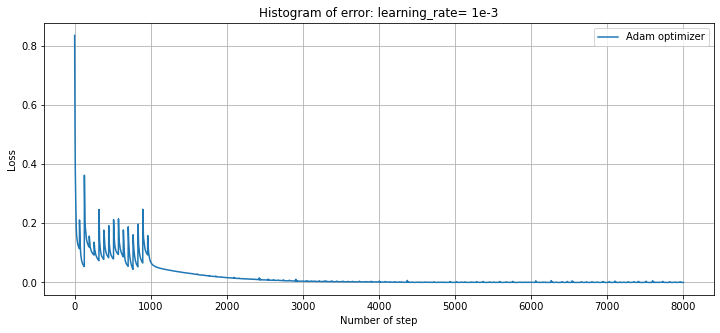

In [114]:
plt.figure(figsize=(12,5))
plt.plot(ff_cnn[1],label='Adam optimizer')
plt.xlabel('Number of step')
plt.ylabel('Loss')
plt.title(r'Histogram of error: learning_rate= 1e-3')
plt.legend()
plt.grid()

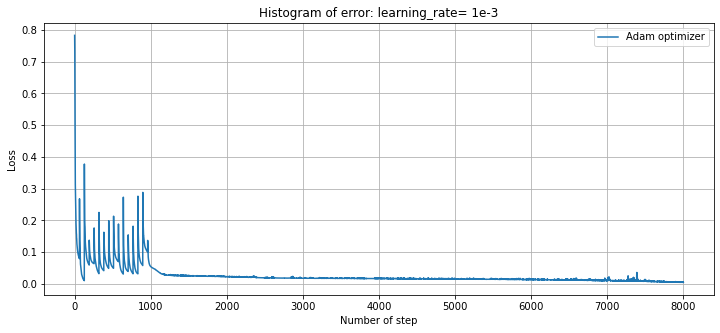

In [58]:
plt.figure(figsize=(12,5))
plt.plot(ff_with_batch[1],label='Adam optimizer')
plt.xlabel('Number of step')
plt.ylabel('Loss')
plt.title(r'Histogram of error: learning_rate= 1e-3')
plt.legend()
plt.grid()

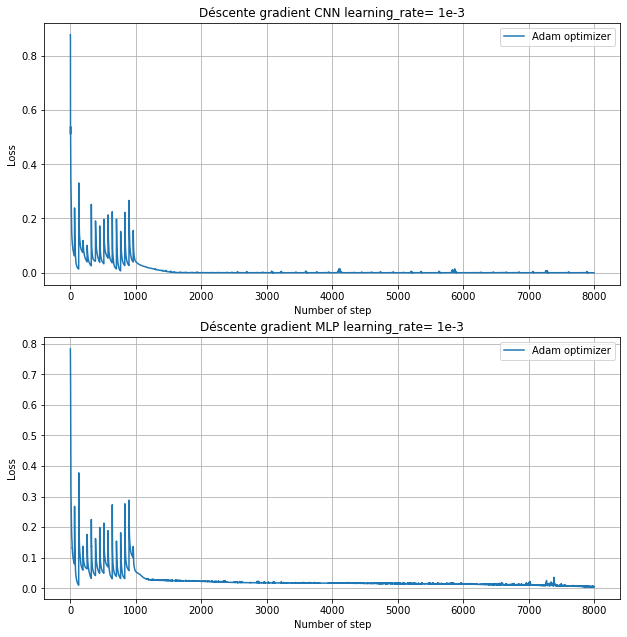

In [59]:
figure = plt.figure(figsize = (20, 20))
plt.gcf().subplots_adjust(left = 0.3, bottom = 0.3,
                       right = 0.7, top = 0.7, wspace = 0, hspace = 0.2)
axes = figure.add_subplot(2, 1, 1)
axes.set_xlabel("Number of step")
axes.set_ylabel('Loss')
axes.set_title('Déscente gradient CNN learning_rate= 1e-3')
axes.plot(ff_cnn[1],label='Adam optimizer')
plt.grid()
plt.legend()

axes = figure.add_subplot(2, 1, 2)
axes.set_xlabel("Number of step")
axes.set_ylabel('Loss')
axes.set_title('Déscente gradient MLP learning_rate= 1e-3')
axes.plot(ff_with_batch[1],label='Adam optimizer')
plt.grid()
plt.legend()

In [60]:
len(ff_cnn[0])

8

In [61]:
pred_Adam_cnn=predict(ff_cnn[0],X)

In [62]:
pred_Adam_cnn

DeviceArray([[ 0.6399483 ,  0.9776654 , -0.8237067 ],
             [ 0.22271933, -0.3859136 , -0.77551776],
             [ 0.47854072,  0.36049536,  0.5637789 ],
             ...,
             [-0.9188406 , -0.37781817, -0.36844906],
             [-0.6173416 ,  0.53049684,  0.05259352],
             [-0.02015112,  0.3298079 ,  0.7893604 ]], dtype=float32)

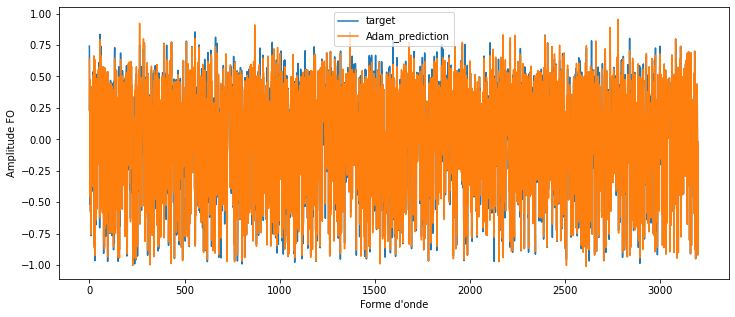

In [63]:
plt.figure(figsize=(12,5))
plt.plot(Y_train_cnn[:,0],label='target')
plt.plot(pred_Adam_cnn[:,0],label='Adam_prediction')
plt.ylabel('Amplitude FO')
plt.xlabel("Forme d'onde")
plt.legend()

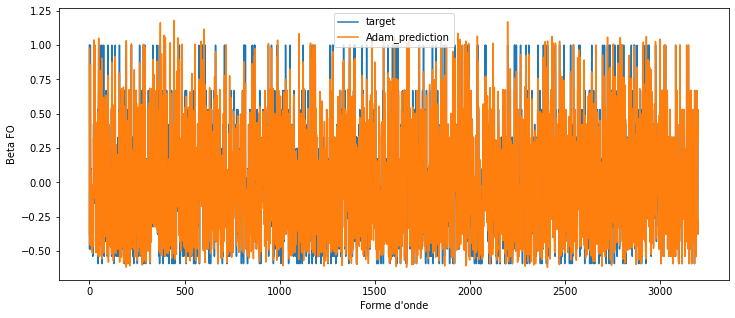

In [64]:
plt.figure(figsize=(12,5))
plt.plot(Y_train_cnn[:,1],label='target')
plt.plot(pred_Adam_cnn[:,1],label='Adam_prediction')
plt.ylabel('Beta FO')
plt.xlabel("Forme d'onde")
plt.legend()

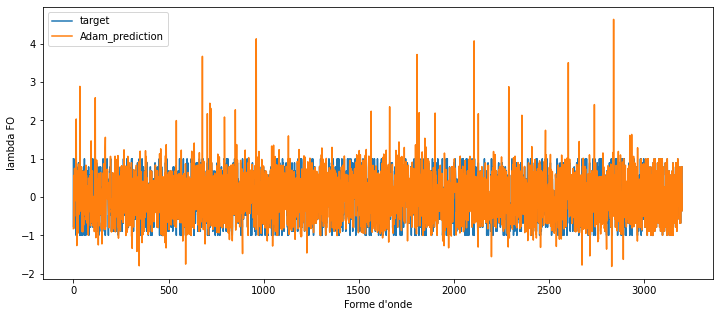

In [65]:
plt.figure(figsize=(12,5))
plt.plot(Y_train_cnn[:,2],label='target')
plt.plot(pred_Adam_cnn[:,2],label='Adam_prediction')
plt.ylabel('lambda FO')
plt.xlabel("Forme d'onde")
plt.legend()

In [66]:
Y_train_cnn[:,2]

array([ 1.        , -0.78947368,  1.        , ..., -0.36842105,
        0.05263158,  0.78947368])

In [67]:
def real_parameter_prediction_cnn(param_test,in_array):
    prediction=predict(param_test[0],in_array)
    Amp_pred=prediction[:,0]*param_test[2][1] + param_test[2][0]
    Bet_pred=prediction[:,1]*param_test[3][1] + param_test[3][0]
    lam_pred=prediction[:,2]*param_test[4][1] + param_test[4][0]
    return np.asarray([(i,j,k)for i,j,k in zip(Amp_pred,Bet_pred,lam_pred)])

In [68]:
X_Tes=np.reshape(X_Te_cnn,(-1,6,256,1))

In [69]:
predT_cnn=real_parameter_prediction_cnn(ff_cnn,X_Tes)

In [70]:
predT_cnn

array([[ 5.0370383e+02,  1.2743926e-01,  2.0265505e+00],
       [ 3.5347794e+02,  1.1202481e+00, -1.1307271e+00],
       [ 5.6633716e+02,  1.6644165e-01,  5.7036239e-01],
       ...,
       [ 8.9449438e+02,  1.4360249e+00, -1.3253465e+00],
       [ 3.1921664e+02,  4.1182423e-01, -1.1962144e+00],
       [ 6.5895844e+02,  6.3139373e-01, -1.0214542e+00]], dtype=float32)

In [71]:
def Y_test_transform_cnn(param_test,Y):
    h_real=Y[:,0]*param_test[2][1] + param_test[2][0]
    b_real=Y[:,1]*param_test[3][1] + param_test[3][0]
    l_real=Y[:,2]*param_test[4][1] + param_test[4][0]
    return np.asarray([(i,j,k)for i,j,k in zip(h_real,b_real,l_real)])

In [72]:
Y_TT_cnn=Y_test_transform_cnn(ff_cnn,Y_test_cnn)

In [73]:
Y_TT_cnn

array([[ 5.15934114e+02,  1.05458525e-01,  1.81881680e+00],
       [ 3.42194237e+02,  1.10784160e+00, -1.65346982e-01],
       [ 5.88544092e+02,  1.05458525e-01,  8.26734909e-01],
       ...,
       [ 8.31127604e+02,  1.57079633e+00,  1.48812284e+00],
       [ 3.22462230e+02,  4.34605526e-01, -1.81881680e+00],
       [ 6.31032220e+02,  6.83588059e-01, -4.96040945e-01]])

In [74]:
mse_loss(ff_cnn[0], X_Tes, Y_TT_cnn)

DeviceArray(305895.53, dtype=float32)

### Visualisation

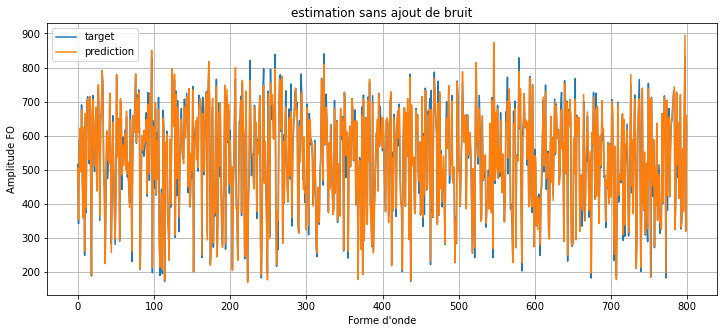

In [75]:
plt.figure(figsize=(12,5))
plt.plot(Y_TT_cnn[:,0],label='target')
plt.plot(predT_cnn[:,0],label='prediction')
plt.ylabel('Amplitude FO')
plt.xlabel("Forme d'onde")
plt.title('estimation sans ajout de bruit')
plt.grid()
plt.legend()

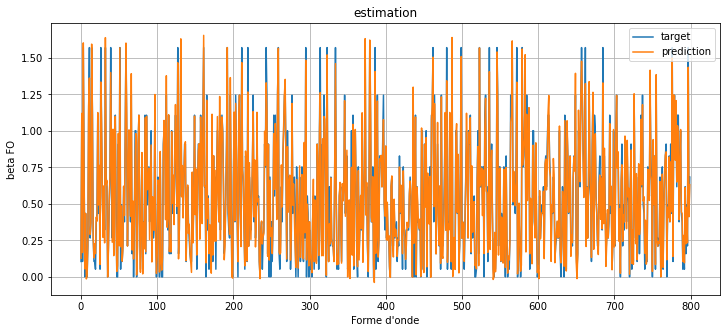

In [76]:
plt.figure(figsize=(12,5))
plt.plot(Y_TT_cnn[:,1],label='target')
plt.plot(predT_cnn[:,1],label='prediction')
plt.ylabel('beta FO')
plt.xlabel("Forme d'onde")
plt.title('estimation')
plt.grid()
plt.legend()

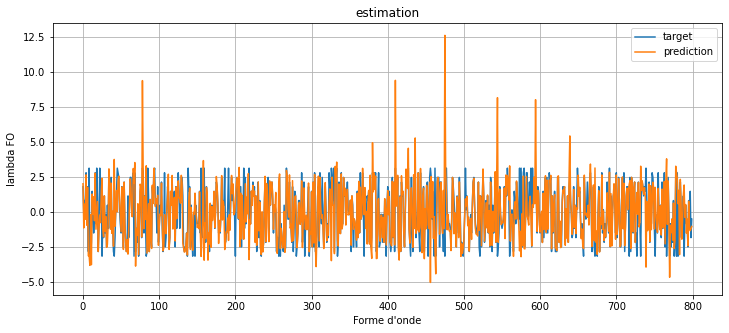

In [77]:
plt.figure(figsize=(12,5))
plt.plot(Y_TT_cnn[:,2],label='target')
plt.plot(predT_cnn[:,2],label='prediction')
plt.ylabel('lambda FO')
plt.xlabel("Forme d'onde")
plt.title('estimation')
plt.grid()
plt.legend()

In [91]:
def LOSS_Hist_cnn(params,in_array,targets):
    preds=real_parameter_prediction_cnn(params,in_array)
    a_error =(preds[:,0]-targets[:,0])/(targets[:,0])
    b_error =(preds[:,1]-targets[:,1])/(targets[:,1]+10e-1)
    l_error =(preds[:,2]-targets[:,2])/(targets[:,2]+10e-1)
    return -20*np.log10(a_error),-20*np.log10(b_error),-20*np.log10(l_error)

In [92]:
a_err_cnn,b_err_cnn,l_err_cnn=LOSS_Hist_cnn(ff_cnn,X_Tes,Y_TT_cnn)

<ipython-input-91-8cbc936d0c11>:6: RuntimeWarning: invalid value encountered in log10
  return -20*np.log10(a_error),-20*np.log10(b_error),-20*np.log10(l_error)


Text(0.5, 1.0, "Histogramme des erreurs d'amplitude sur le Test_Set")

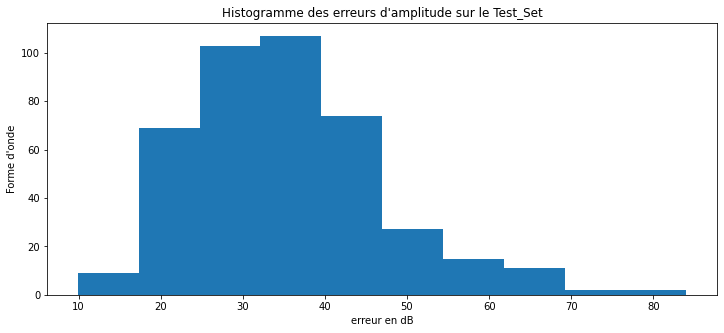

In [93]:
plt.figure(figsize=(12,5))
out=plt.hist(np.array(a_err_cnn))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs d\'amplitude sur le Test_Set')



Text(0.5, 1.0, 'Histogramme des erreurs de beta sur le Test_Set')

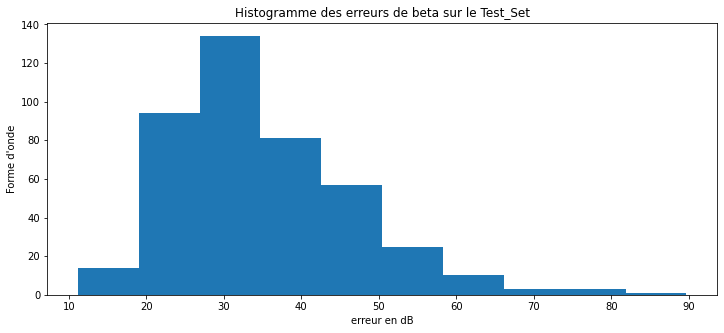

In [94]:
plt.figure(figsize=(12,5))
out=plt.hist(np.array(b_err_cnn))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs de beta sur le Test_Set')



Text(0.5, 1.0, 'Histogramme des erreurs de lambda sur le Test_Set')

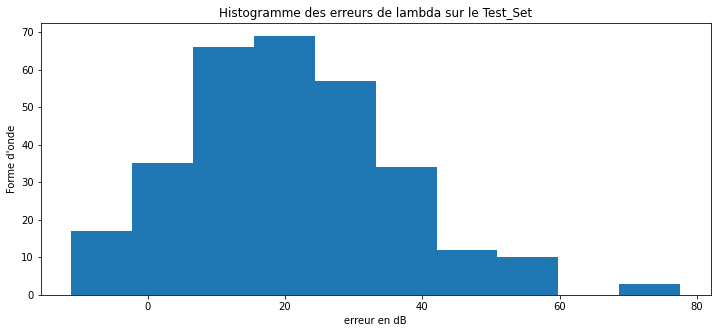

In [95]:
plt.figure(figsize=(12,5))
out=plt.hist(np.array(l_err_cnn))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs de lambda sur le Test_Set')


